In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
data = pd.read_excel('/content/drive/MyDrive/YuxianWang_summer-2024/data/Assignment 3 - timeseries_data.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

In [186]:
data.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


In [187]:
data.describe()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,YEAR
count,14987,14987.000000,14982.000000,14983.000000,14987.000000,14987.000000,14987,14987.000000
mean,2017-11-09 06:41:09.340094720,25.766417,7532.436283,291.989714,42371.673703,12.495763,2017-11-08 18:11:24.593314304,2017.415493
min,2017-01-01 01:00:00,-17.860000,54.440000,0.000000,25566.511248,1.000000,2017-01-01 00:00:00,2017.000000
25%,2017-06-06 04:30:00,18.041250,4135.630000,0.000000,35431.636526,6.000000,2017-06-06 00:00:00,2017.000000
50%,2017-11-09 06:00:00,20.057500,7281.445000,22.150000,39934.007113,12.000000,2017-11-09 00:00:00,2017.000000
75%,2018-04-14 09:30:00,25.030000,10851.647500,608.635000,47873.100786,18.000000,2018-04-14 00:00:00,2018.000000
max,2018-09-17 12:00:00,2809.357500,20350.400000,1257.540000,73264.662123,24.000000,2018-09-17 00:00:00,2018.000000
std,NaN,46.361945,3992.884834,370.914596,9874.339631,6.922309,NaN,0.492823


In [188]:
#RTLMP <= 0
data[data['HB_NORTH (RTLMP)']<= 0]

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
215,2017-01-10 00:00:00,-0.7275,13595.25,0.11,31698.628648,24,2017-01-09,OFFPEAK,JANUARY,2017
216,2017-01-10 01:00:00,-1.3475,12689.74,0.11,30008.881835,1,2017-01-10,OFFPEAK,JANUARY,2017
217,2017-01-10 02:00:00,-13.6075,11832.67,0.11,28994.028000,2,2017-01-10,OFFPEAK,JANUARY,2017
218,2017-01-10 03:00:00,-11.4800,11570.82,0.11,28449.908768,3,2017-01-10,OFFPEAK,JANUARY,2017
219,2017-01-10 04:00:00,-6.4375,11589.81,0.11,28361.885145,4,2017-01-10,OFFPEAK,JANUARY,2017
...,...,...,...,...,...,...,...,...,...,...
11764,2018-05-06 06:00:00,-0.3725,7527.36,0.00,28342.826930,6,2018-05-06,OFFPEAK,MAY,2018
11785,2018-05-07 03:00:00,-0.3850,10555.14,0.00,30368.989020,3,2018-05-07,OFFPEAK,MAY,2018
11786,2018-05-07 04:00:00,-4.2225,10279.85,0.00,29645.938020,4,2018-05-07,OFFPEAK,MAY,2018
13612,2018-07-22 06:00:00,-0.5500,10041.22,0.00,41799.389448,6,2018-07-22,OFFPEAK,JULY,2018


In [189]:
#Set index
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.set_index('DATETIME', inplace=True)

# Handle duplicates
data = data[~data.index.duplicated(keep='first')]

# Time frequency
data = data.asfreq('H')



In [190]:
# Find rows with null
null_rows = data[data.isnull().any(axis=1)]

#Check
print("Rows with null values:")
print(null_rows)
#DST



Rows with null values:
                     HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
DATETIME                                                  
2017-03-12 03:00:00               NaN               NaN   
2017-11-05 01:00:00           17.3375          13272.17   
2017-11-05 02:00:00           16.5675               NaN   
2018-03-11 02:00:00           13.0725               NaN   
2018-03-11 03:00:00               NaN               NaN   
2018-09-17 11:00:00           29.6700               NaN   
2018-09-17 12:00:00           33.6607               NaN   

                     ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  \
DATETIME                                                                       
2017-03-12 03:00:00                          NaN             NaN         NaN   
2017-11-05 01:00:00                          NaN    35745.976145         1.0   
2017-11-05 02:00:00                          NaN    34032.269078         2.0   
2018-03-11 02:00:00                         0

In [191]:
# Delete
data = data.dropna()

#Check again
print("Missing values after handling:")
print(data.isnull().sum())

Missing values after handling:
HB_NORTH (RTLMP)               0
ERCOT (WIND_RTI)               0
ERCOT (GENERATION_SOLAR_RT)    0
ERCOT (RTLOAD)                 0
HOURENDING                     0
MARKETDAY                      0
PEAKTYPE                       0
MONTH                          0
YEAR                           0
dtype: int64


# EDA

In [192]:
data['month'] = data.index.month
data['weekday'] = data.index.weekday
data['DATE'] = data.index.strftime('%m-%d')


In [193]:
data

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,month,weekday,DATE
DATETIME,,,,,,,,,,,,
2017-01-01 01:00:00,23.3575,2155.31,0.00,29485.791355,1.0,2017-01-01,OFFPEAK,JANUARY,2017.0,1,6,01-01
2017-01-01 02:00:00,21.4650,2313.81,0.00,28911.565913,2.0,2017-01-01,OFFPEAK,JANUARY,2017.0,1,6,01-01
2017-01-01 03:00:00,20.7350,2587.68,0.00,28238.258175,3.0,2017-01-01,OFFPEAK,JANUARY,2017.0,1,6,01-01
2017-01-01 04:00:00,20.2700,2748.65,0.00,27821.000513,4.0,2017-01-01,OFFPEAK,JANUARY,2017.0,1,6,01-01
2017-01-01 05:00:00,20.1200,2757.49,0.00,27646.942413,5.0,2017-01-01,OFFPEAK,JANUARY,2017.0,1,6,01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-17 06:00:00,20.3950,3094.87,0.00,37923.340000,6.0,2018-09-17,OFFPEAK,SEPTEMBER,2018.0,9,0,09-17
2018-09-17 07:00:00,20.8800,3325.27,0.00,40936.180000,7.0,2018-09-17,WDPEAK,SEPTEMBER,2018.0,9,0,09-17
2018-09-17 08:00:00,20.8600,3195.52,2.04,41902.240000,8.0,2018-09-17,WDPEAK,SEPTEMBER,2018.0,9,0,09-17


In [194]:
data_2017 = data[data['YEAR']==2017]
data_2018 = data[data['YEAR']==2018]



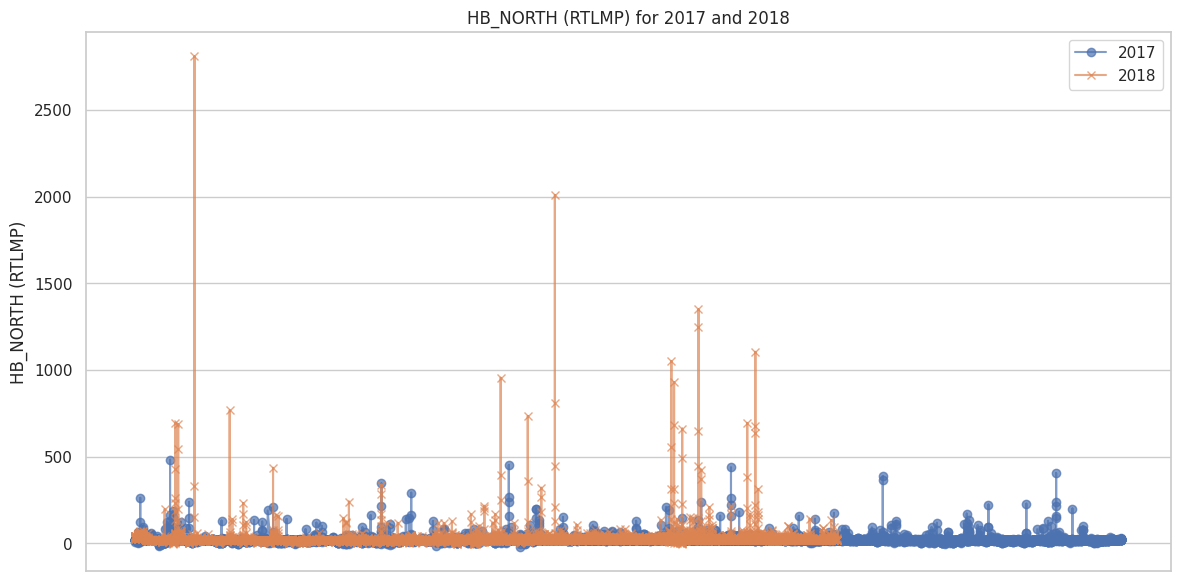

In [195]:
# Set figure
plt.figure(figsize=(14, 7))

# 2017
plt.plot(data_2017['DATE'], data_2017['HB_NORTH (RTLMP)'], label='2017', linestyle='-', marker='o', alpha=0.7)

# 2018
plt.plot(data_2018['DATE'], data_2018['HB_NORTH (RTLMP)'], label='2018', linestyle='-', marker='x', alpha=0.7)

plt.title('HB_NORTH (RTLMP) for 2017 and 2018')
plt.xlabel('Date')
plt.ylabel('HB_NORTH (RTLMP)')
plt.legend()
plt.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)

plt.show()


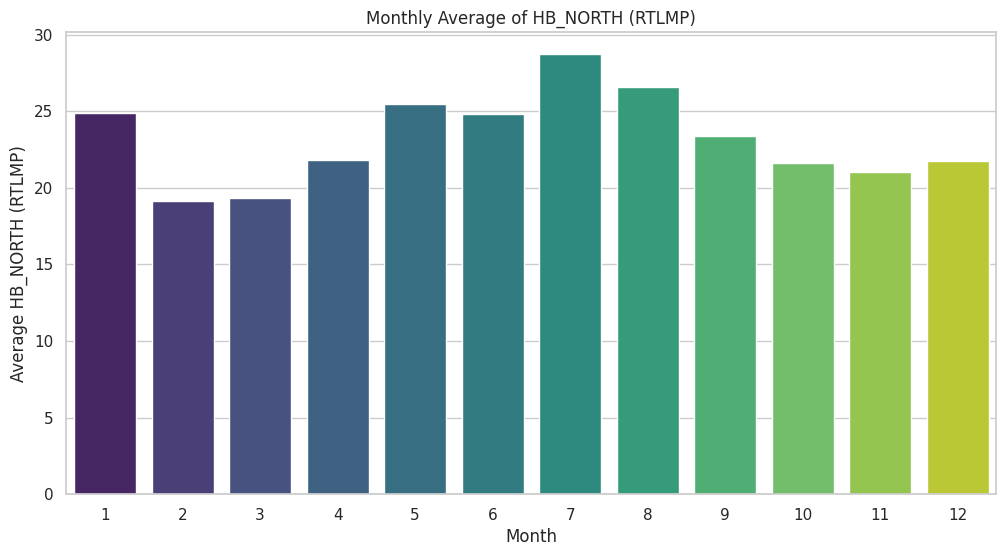

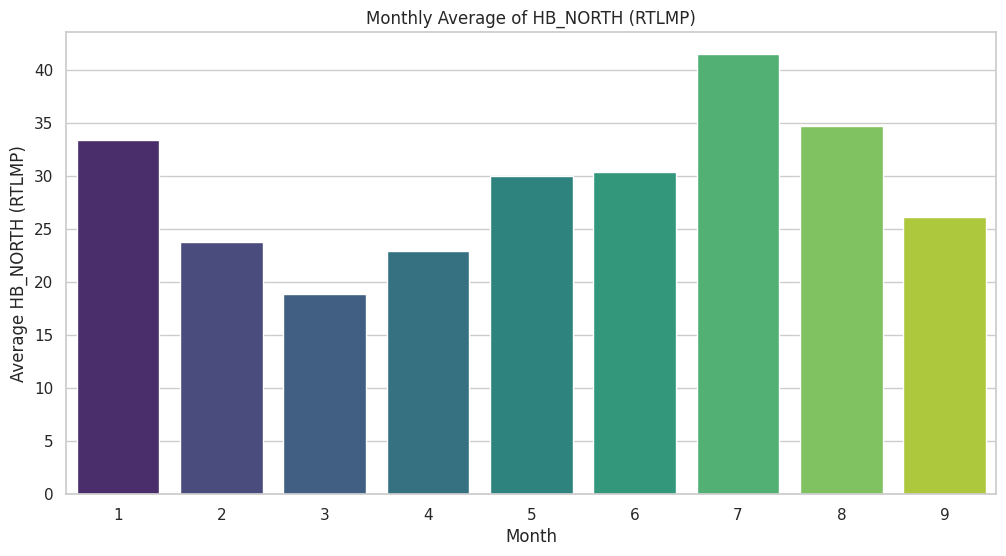

In [196]:
# Month
monthly_avg2017 = data[data['YEAR']==2017].groupby('month')['HB_NORTH (RTLMP)'].mean().reset_index()
monthly_avg2018 = data[data['YEAR']==2018].groupby('month')['HB_NORTH (RTLMP)'].mean().reset_index()


sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='HB_NORTH (RTLMP)', data=monthly_avg2017, palette='viridis')
plt.title('Monthly Average of HB_NORTH (RTLMP)')
plt.xlabel('Month')
plt.ylabel('Average HB_NORTH (RTLMP)')

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='HB_NORTH (RTLMP)', data=monthly_avg2018, palette='viridis')
plt.title('Monthly Average of HB_NORTH (RTLMP)')
plt.xlabel('Month')
plt.ylabel('Average HB_NORTH (RTLMP)')
plt.show()



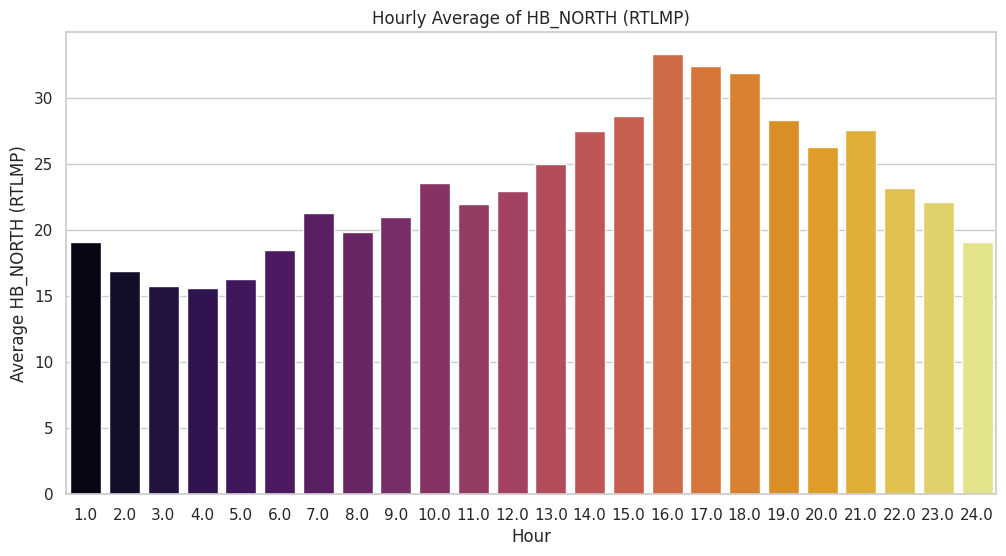

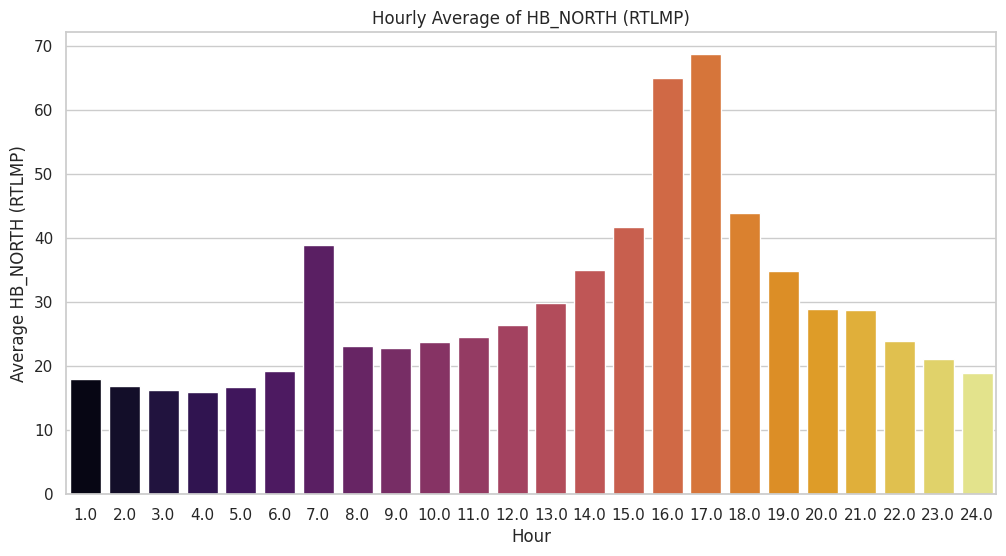

In [197]:
# Hour
hourly_avg2017 = data[data['YEAR']==2017].groupby('HOURENDING')['HB_NORTH (RTLMP)'].mean().reset_index()
hourly_avg2018 = data[data['YEAR']==2018].groupby('HOURENDING')['HB_NORTH (RTLMP)'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(x='HOURENDING', y='HB_NORTH (RTLMP)', data=hourly_avg2017, palette='inferno')
plt.title('Hourly Average of HB_NORTH (RTLMP)')
plt.xlabel('Hour')
plt.ylabel('Average HB_NORTH (RTLMP)')

plt.figure(figsize=(12, 6))
sns.barplot(x='HOURENDING', y='HB_NORTH (RTLMP)', data=hourly_avg2018, palette='inferno')
plt.title('Hourly Average of HB_NORTH (RTLMP)')
plt.xlabel('Hour')
plt.ylabel('Average HB_NORTH (RTLMP)')
plt.show()



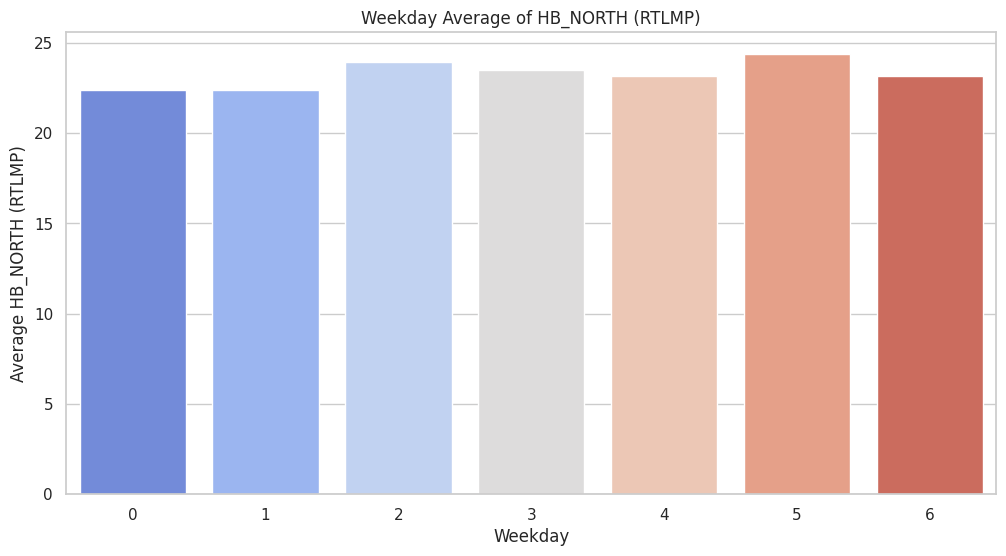

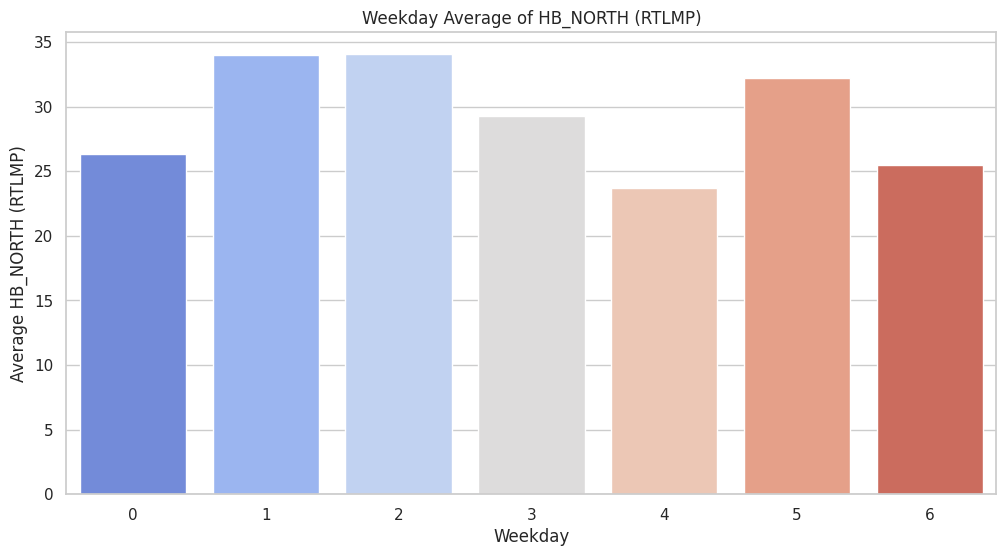

In [198]:
# Weekday
weekday_avg2017 = data[data['YEAR']==2017].groupby('weekday')['HB_NORTH (RTLMP)'].mean().reset_index()
weekday_avg2018 = data[data['YEAR']==2018].groupby('weekday')['HB_NORTH (RTLMP)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='weekday', y='HB_NORTH (RTLMP)', data=weekday_avg2017, palette='coolwarm')
plt.title('Weekday Average of HB_NORTH (RTLMP)')
plt.xlabel('Weekday')
plt.ylabel('Average HB_NORTH (RTLMP)')

plt.figure(figsize=(12, 6))
sns.barplot(x='weekday', y='HB_NORTH (RTLMP)', data=weekday_avg2018, palette='coolwarm')
plt.title('Weekday Average of HB_NORTH (RTLMP)')
plt.xlabel('Weekday')
plt.ylabel('Average HB_NORTH (RTLMP)')
plt.show()


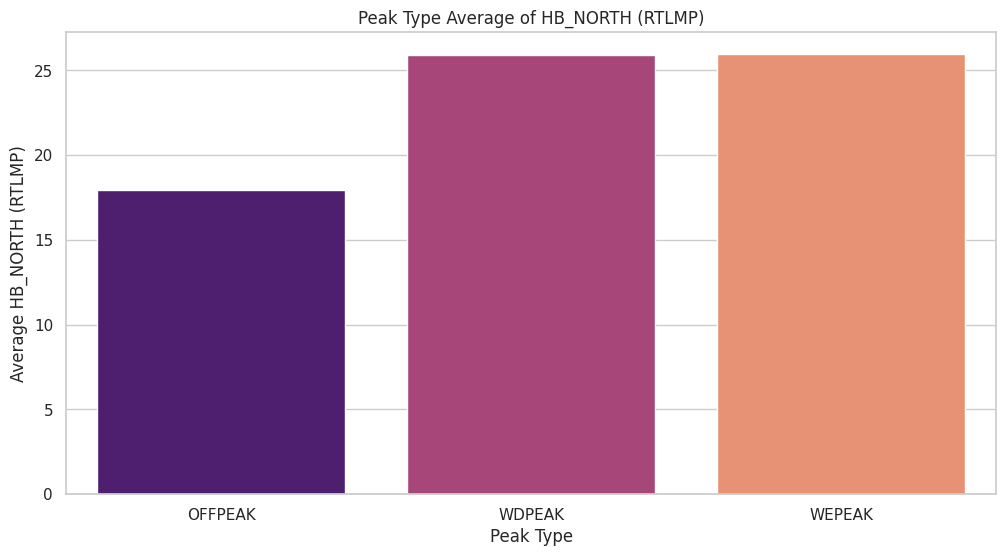

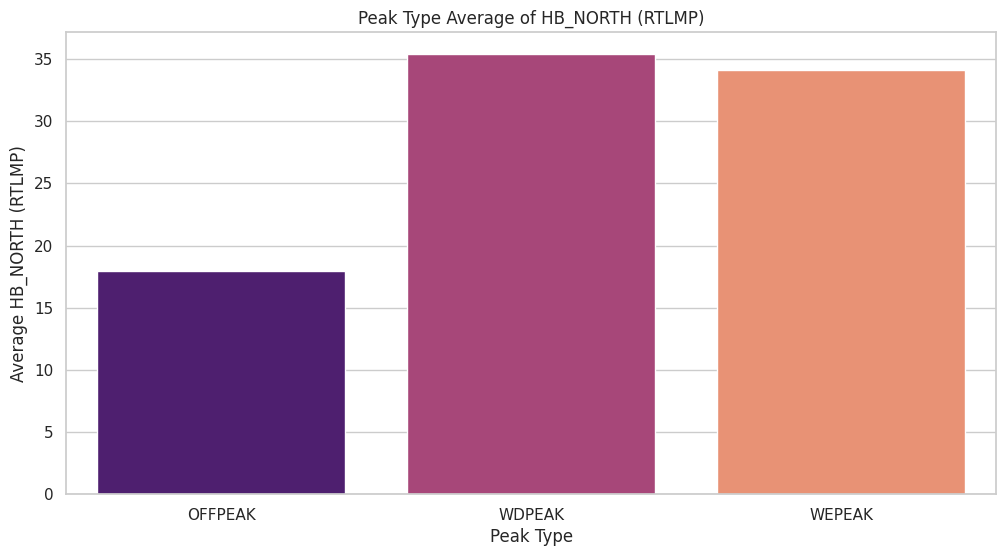

In [199]:
# PeakType
peaktype_avg2017 = data[data['YEAR']==2017].groupby('PEAKTYPE')['HB_NORTH (RTLMP)'].mean().reset_index()
peaktype_avg2018 = data[data['YEAR']==2018].groupby('PEAKTYPE')['HB_NORTH (RTLMP)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='PEAKTYPE', y='HB_NORTH (RTLMP)', data=peaktype_avg2017, palette='magma')
plt.title('Peak Type Average of HB_NORTH (RTLMP)')
plt.xlabel('Peak Type')
plt.ylabel('Average HB_NORTH (RTLMP)')

plt.figure(figsize=(12, 6))
sns.barplot(x='PEAKTYPE', y='HB_NORTH (RTLMP)', data=peaktype_avg2018, palette='magma')
plt.title('Peak Type Average of HB_NORTH (RTLMP)')
plt.xlabel('Peak Type')
plt.ylabel('Average HB_NORTH (RTLMP)')
plt.show()

Text(0, 0.5, 'Average ERCOT (GENERATION_SOLAR_RT)\t')

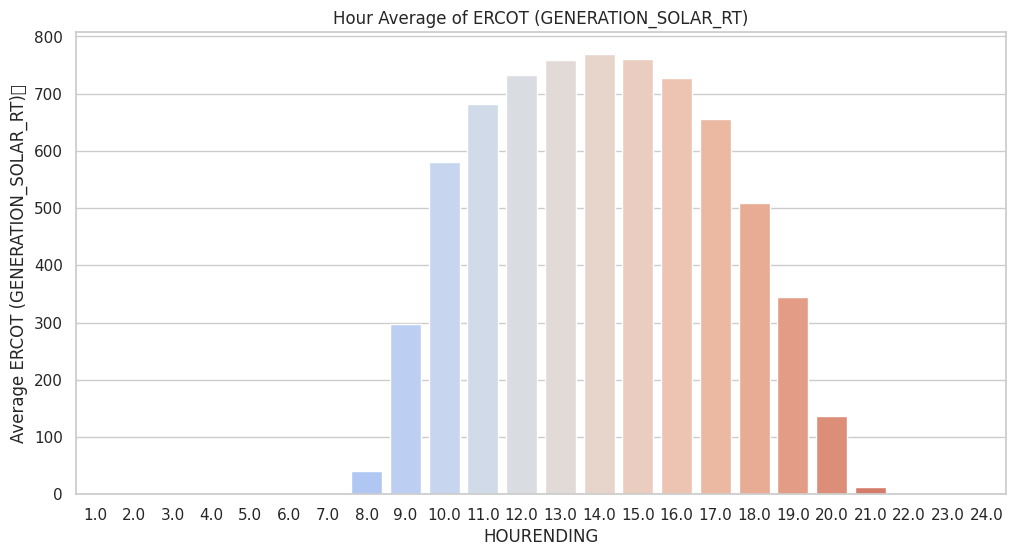

In [200]:
# Weekday
weekday_avg = data.groupby('HOURENDING')['ERCOT (GENERATION_SOLAR_RT)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='HOURENDING', y='ERCOT (GENERATION_SOLAR_RT)', data=weekday_avg, palette='coolwarm')
plt.title('Hour Average of ERCOT (GENERATION_SOLAR_RT)')
plt.xlabel('HOURENDING')
plt.ylabel('Average ERCOT (GENERATION_SOLAR_RT)	')


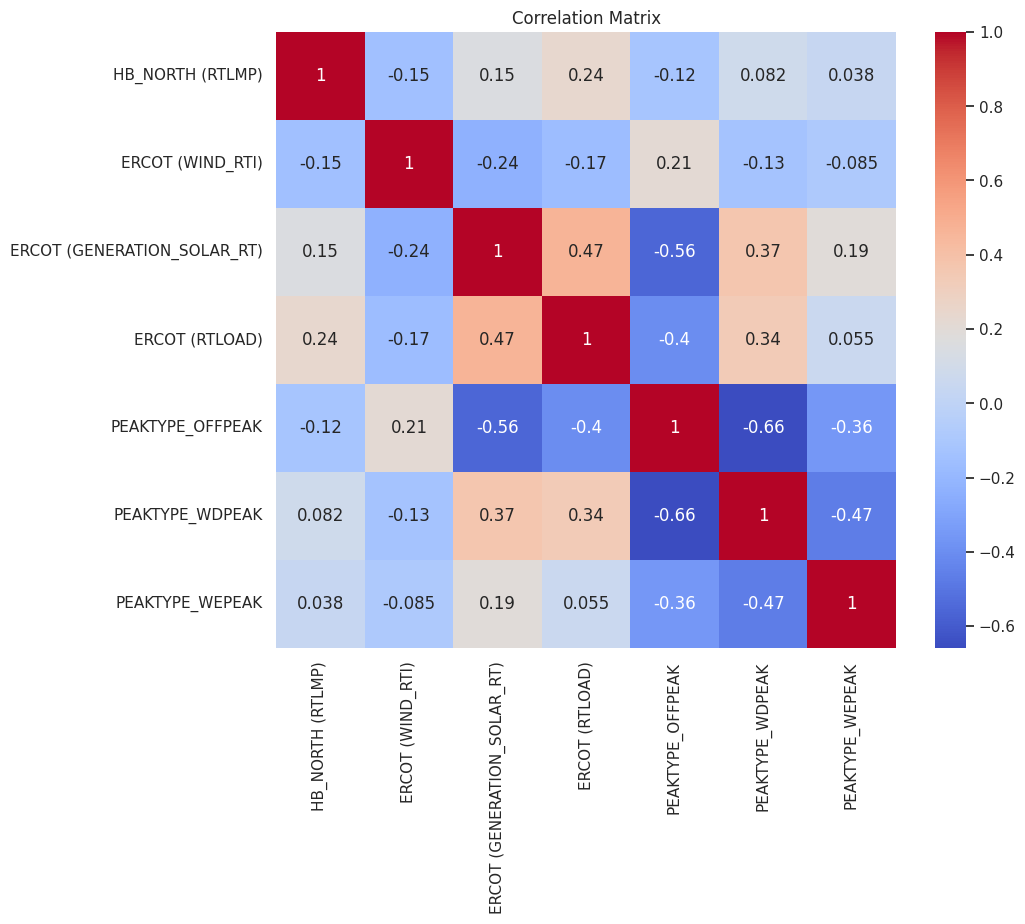

In [201]:
# One-Hot Encoding
data = pd.get_dummies(data, columns=['PEAKTYPE'])
# Correlation Matrix
features = ['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)',
            'ERCOT (RTLOAD)','PEAKTYPE_OFFPEAK', 'PEAKTYPE_WDPEAK','PEAKTYPE_WEPEAK']
correlation_matrix = data[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# LSTM for Prediction

In [202]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [203]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Tue May 21 14:50:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              31W /  70W |   5689MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [204]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_excel('/content/drive/MyDrive/YuxianWang_summer-2024/data/Assignment 3 - timeseries_data.xlsx')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
#Set Datetime and index
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.set_index('DATETIME', inplace=True)

# Delete duplicates
data = data[~data.index.duplicated(keep='first')]

# Time frequency
data = data.asfreq('H')


In [206]:
#Missing value
print(data.isnull().sum())
null_rows = data[data.isnull().any(axis=1)]

#Check
print(null_rows) #DST

# Delete
data = data.dropna()

#Check
print(data.isnull().sum())

Missing values before handling:
HB_NORTH (RTLMP)               2
ERCOT (WIND_RTI)               6
ERCOT (GENERATION_SOLAR_RT)    5
ERCOT (RTLOAD)                 2
HOURENDING                     2
MARKETDAY                      2
PEAKTYPE                       2
MONTH                          2
YEAR                           2
dtype: int64


In [209]:
data

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
DATETIME,,,,,,,,,
2017-01-01 01:00:00,23.3575,2155.31,0.00,29485.791355,1.0,2017-01-01,OFFPEAK,JANUARY,2017.0
2017-01-01 02:00:00,21.4650,2313.81,0.00,28911.565913,2.0,2017-01-01,OFFPEAK,JANUARY,2017.0
2017-01-01 03:00:00,20.7350,2587.68,0.00,28238.258175,3.0,2017-01-01,OFFPEAK,JANUARY,2017.0
2017-01-01 04:00:00,20.2700,2748.65,0.00,27821.000513,4.0,2017-01-01,OFFPEAK,JANUARY,2017.0
2017-01-01 05:00:00,20.1200,2757.49,0.00,27646.942413,5.0,2017-01-01,OFFPEAK,JANUARY,2017.0
...,...,...,...,...,...,...,...,...,...
2018-09-17 06:00:00,20.3950,3094.87,0.00,37923.340000,6.0,2018-09-17,OFFPEAK,SEPTEMBER,2018.0
2018-09-17 07:00:00,20.8800,3325.27,0.00,40936.180000,7.0,2018-09-17,WDPEAK,SEPTEMBER,2018.0
2018-09-17 08:00:00,20.8600,3195.52,2.04,41902.240000,8.0,2018-09-17,WDPEAK,SEPTEMBER,2018.0


In [210]:
# One-Hot Encoding
data = pd.get_dummies(data, columns=['PEAKTYPE'])

#Feature
features = ['HB_NORTH (RTLMP)','ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)',
            'ERCOT (RTLOAD)','PEAKTYPE_OFFPEAK', 'PEAKTYPE_WDPEAK','PEAKTYPE_WEPEAK']
#Target
target = 'HB_NORTH (RTLMP)'

# Standarlize
fea_scaler = StandardScaler()
data[features] = fea_scaler.fit_transform(data[features])
target_scaler = StandardScaler()
data[target] = target_scaler.fit_transform(data[[target]].values)




In [211]:
# Create sequence with lag
def create_sequences(data, target, lag): 
    X = []
    y = []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(target[i+lag])
    return np.array(X), np.array(y)

In [212]:
#Develop LSTM for prediction
class LSTM(nn.Module):
    def __init__(self, input_size):
        super(LSTM, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=512, num_layers=2, batch_first=True, dropout=0.3) #Dropout for overfitting problem

        # Dense Layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x)

        # Last time step
        x = lstm_out[:, -1, :]

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [213]:
#Conduct cross validation for optimal lag
def cross_validate_lag(data, target, lags, cv_splits=5, patience=10, epochs=70):
    #Split
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    results = {}

    for lag in lags:
        X, y = create_sequences(data, target, lag)
        X = torch.tensor(X, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

        fold_mse = []

        #Split for cross validation
        for train_index, val_index in tscv.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            #Model, loss function, and optimizer
            model = LSTM(input_size=X.shape[2]).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            best_val_loss = float('inf')
            patience_counter = 0

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                output = model(X_train)
                loss = criterion(output, y_train)
                loss.backward()
                optimizer.step()

                torch.cuda.empty_cache()  # Clean GPU memory

                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    val_output = model(X_val)
                    val_loss = criterion(val_output, y_val).item()

                #Early stop
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    break

            model.eval()
            with torch.no_grad():
                val_pred = model(X_val)
                val_mse = mean_squared_error(y_val.cpu().numpy(), val_pred.cpu().numpy())
                fold_mse.append(val_mse)

            #Clean GPU memory
            del X_train, X_val, y_train, y_val, model
            torch.cuda.empty_cache()

        results[lag] = np.mean(fold_mse)
        print(f'Lag: {lag}, MSE: {results[lag]:.4f}')

    optimal_lag = min(results, key=results.get)
    return optimal_lag, results
# Optimal lag
lags = list(range(1, 23))
optimal_lag, results = cross_validate_lag(data[features].values, data[target].values, lags)

print(f'Optimal lag: {optimal_lag}')

Lag: 1, MSE: 0.7733
Lag: 2, MSE: 0.7870
Lag: 3, MSE: 0.7543
Lag: 4, MSE: 0.7589
Lag: 5, MSE: 0.7655
Lag: 6, MSE: 0.7792
Lag: 7, MSE: 0.7775
Lag: 8, MSE: 0.7658
Lag: 9, MSE: 0.7697
Lag: 10, MSE: 0.7697
Lag: 11, MSE: 0.7763
Lag: 12, MSE: 0.7864
Lag: 13, MSE: 0.7820
Lag: 14, MSE: 0.7758
Lag: 15, MSE: 0.7902
Lag: 16, MSE: 0.7867
Lag: 17, MSE: 0.7574
Lag: 18, MSE: 0.7896
Lag: 19, MSE: 0.7573
Lag: 20, MSE: 0.7882
Lag: 21, MSE: 0.7755
Lag: 22, MSE: 0.7705
Optimal lag: 3


In [223]:
# Create sequqnces and split training set and test set
X, y = create_sequences(data[features].values, data[target].values,optimal_lag)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

# Transform to torch and create Dataloader for GPU memory problem
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM model
model = LSTM(input_size=X_train.shape[2]).to(device)

# Loss function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with eraly stop
epochs = 200
patience = 20 #Early stop parameter
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'

for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_output = model(X_batch)
            val_loss += criterion(val_output, y_batch).item()
    val_loss /= len(test_loader)

    #Early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

# Load best model
model.load_state_dict(torch.load(best_model_path))

# Evaluation on test set
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        val_output = model(X_batch)
        test_loss += criterion(val_output, y_batch).item()
        predictions.append(val_output.cpu().numpy())
test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')


# RMSE, R-square
predictions = np.concatenate(predictions).flatten()
test_rmse = np.sqrt(test_loss)
print(f'Test RMSE: {test_rmse:.4f}')


r2 = r2_score(y_test, predictions)
print(f'Test R²: {r2:.4f}')

Epoch [10/200], Loss: 0.0028, Val Loss: 1.1473
Epoch [20/200], Loss: 0.1505, Val Loss: 0.7075
Epoch [30/200], Loss: 0.0624, Val Loss: 1.1348
Epoch [40/200], Loss: 0.0149, Val Loss: 1.0739
Early stopping at epoch 46
Test Loss: 0.6300
Test RMSE: 0.7937
Test R²: 0.6079


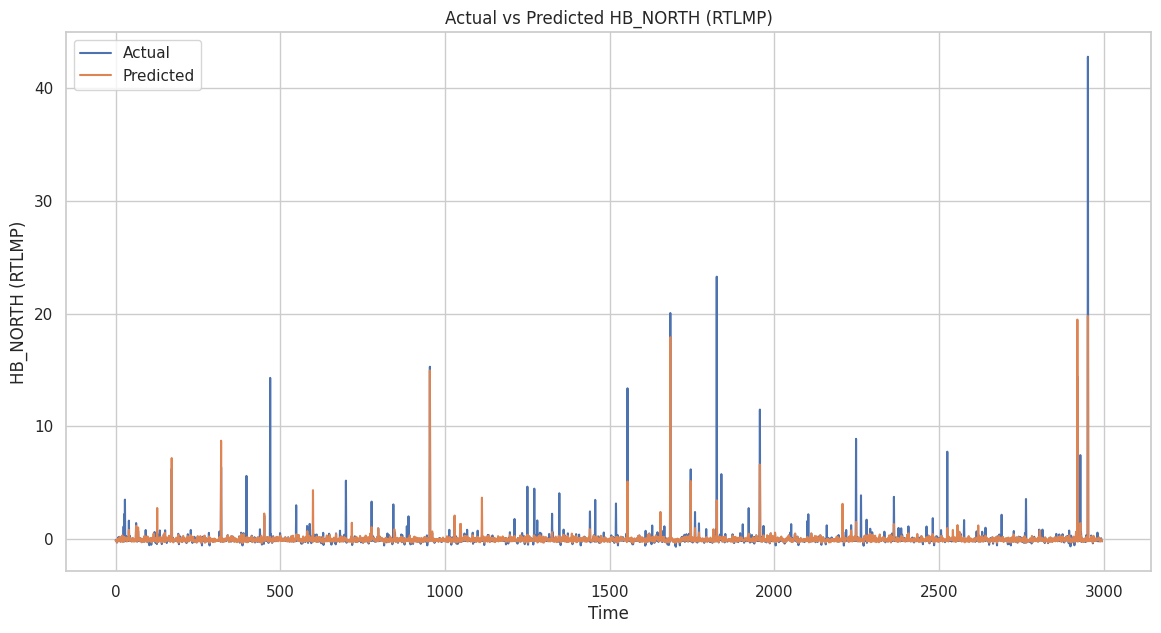

In [224]:
# Visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted HB_NORTH (RTLMP)')
plt.xlabel('Time')
plt.ylabel('HB_NORTH (RTLMP)')
plt.legend()
plt.show()

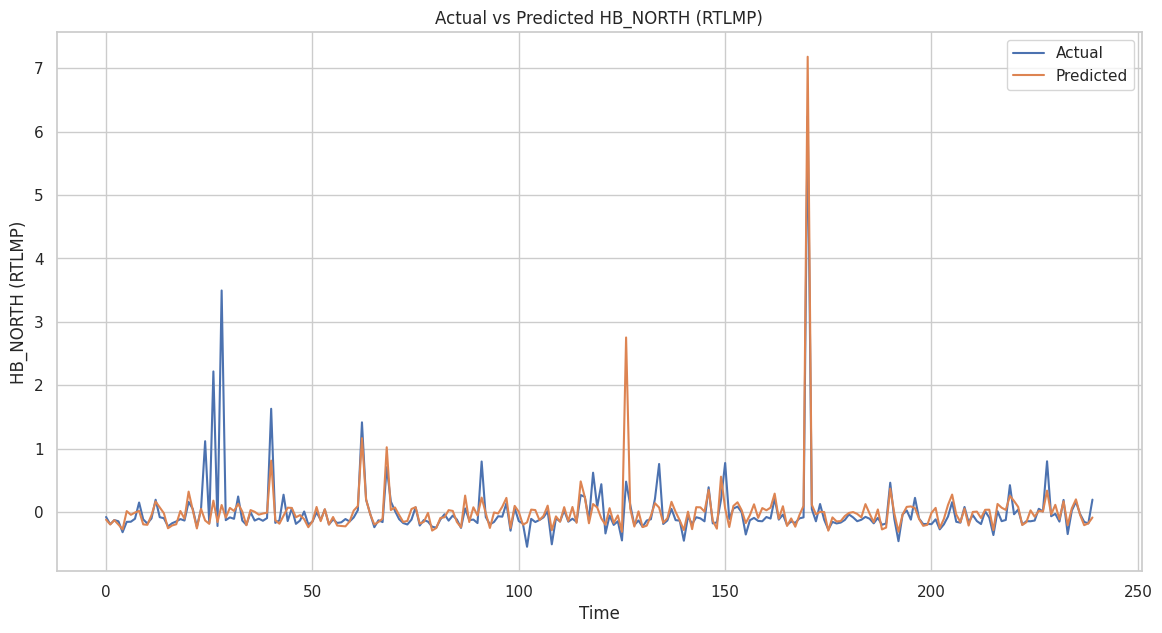

In [225]:
# Visualization 240 hours, 10 days
plt.figure(figsize=(14, 7))
plt.plot(y_test[:240], label='Actual')
plt.plot(predictions[:240], label='Predicted')
plt.title('Actual vs Predicted HB_NORTH (RTLMP)')
plt.xlabel('Time')
plt.ylabel('HB_NORTH (RTLMP)')
plt.legend()
plt.show()

## Log Transformation

In [226]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_excel('/content/drive/MyDrive/YuxianWang_summer-2024/data/Assignment 3 - timeseries_data.xlsx')


data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.set_index('DATETIME', inplace=True)

# Delete duplicates
data = data[~data.index.duplicated(keep='first')]

# Time frequency
data = data.asfreq('H')

#Missing value
null_rows = data[data.isnull().any(axis=1)]
print(null_rows) #DST

# Delete
data = data.dropna()

#Check
print(data.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                     HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
DATETIME                                                  
2017-03-12 03:00:00               NaN               NaN   
2017-11-05 01:00:00           17.3375          13272.17   
2017-11-05 02:00:00           16.5675               NaN   
2018-03-11 02:00:00           13.0725               NaN   
2018-03-11 03:00:00               NaN               NaN   
2018-09-17 11:00:00           29.6700               NaN   
2018-09-17 12:00:00           33.6607               NaN   

                     ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  \
DATETIME                                                                       
2017-03-12 03:00:00                          NaN             NaN         NaN   
2017-11-05 01:00:00                          NaN    35745.976145         1.0   
2017-11-05 02:00:00

In [227]:
# One-Hot Encoding
data = pd.get_dummies(data, columns=['PEAKTYPE'])
# Features and target
features = ['ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)',
            'ERCOT (RTLOAD)', 'PEAKTYPE_OFFPEAK', 'PEAKTYPE_WDPEAK', 'PEAKTYPE_WEPEAK']
target = 'HB_NORTH (RTLMP)'

# Standarlize
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Exponential transformation
data['target_log'] = np.log1p(data[target] - data[target].min() + 1)  # 确保所有值为正
target_log = 'target_log'

features= ['ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)',
            'ERCOT (RTLOAD)', 'PEAKTYPE_OFFPEAK', 'PEAKTYPE_WDPEAK', 'PEAKTYPE_WEPEAK','target_log']


In [229]:
def create_sequences(data, target, lag):
    X = []
    y = []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(target[i+lag])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [150]:
# Develop LSTM for prediction
class LSTM(nn.Module):
    def __init__(self, input_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=512, num_layers=2, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [230]:
# Create sequqnces and split training set and test set
optimal_lag = 4
X, y = create_sequences(data[features].values, data[target_log].values, optimal_lag)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

# Transform to torch and create Dataloader for GPU memory problem
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM model
model = LSTM(input_size=X_train.shape[2]).to(device)

# Loss function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with eraly stop
epochs = 200
patience = 10  #Early stop parameter
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'

for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_output = model(X_batch)
            val_loss += criterion(val_output, y_batch).item()
    val_loss /= len(test_loader)

    #Early Stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

# Load best model
model.load_state_dict(torch.load(best_model_path))

# Evaluation on test set
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        val_output = model(X_batch)
        test_loss += criterion(val_output, y_batch).item()
        predictions.append(val_output.cpu().numpy())
test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')


# RMSE, R-square
predictions = np.concatenate(predictions).flatten()
test_rmse = np.sqrt(test_loss)
print(f'Test RMSE: {test_rmse:.4f}')

r2 = r2_score(y_test, predictions)
print(f'Test R²: {r2:.4f}')


Epoch [10/200], Loss: 0.1757, Val Loss: 0.0454
Epoch [20/200], Loss: 0.0038, Val Loss: 0.0386
Epoch [30/200], Loss: 0.0071, Val Loss: 0.0371
Early stopping at epoch 33
Test Loss: 0.0323
Test RMSE: 0.1798
Test R²: 0.6754


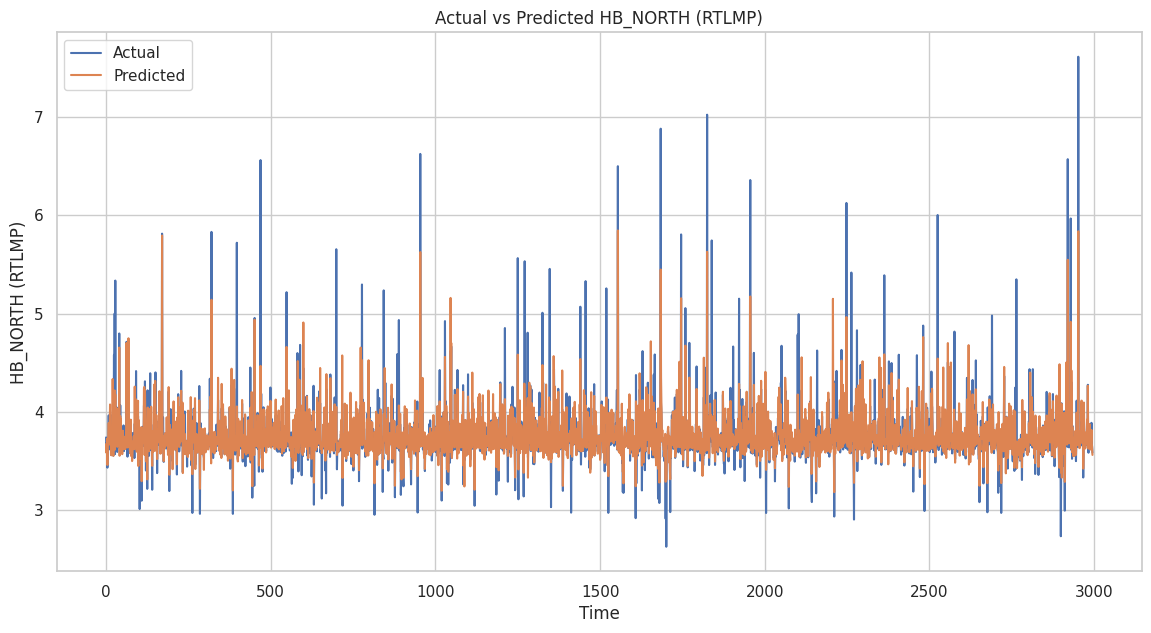

In [231]:
# Result
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted HB_NORTH (RTLMP)')
plt.xlabel('Time')
plt.ylabel('HB_NORTH (RTLMP)')
plt.legend()
plt.show()